In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm, trange

In [2]:
import torch
import torch.nn as nn

In [3]:
df = pd.read_csv('data/sp500/csv/AAPL.csv', parse_dates=['Date'], date_format='%d-%m-%Y')


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862,0.092492
...,...,...,...,...,...,...,...
10585,2022-12-06,141.919998,147.070007,64727200,147.300003,142.910004,142.910004
10586,2022-12-07,140.000000,142.190002,69721100,143.369995,140.940002,140.940002
10587,2022-12-08,141.100006,142.360001,62128300,143.520004,142.649994,142.649994
10588,2022-12-09,140.899994,142.339996,76069500,145.570007,142.160004,142.160004


In [4]:
df['RateOfReturn'] = (df['Close'] - df['Close'].shift(1))/df['Close'].shift(1)
df

,Date,Low,Open,Volume,High,Close,Adjusted Close,RateOfReturn
0,1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348,0.099874,NaN
1,1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652,0.094663,-0.052171
2,1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723,0.087715,-0.073398
3,1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513,0.089886,0.024751
4,1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862,0.092492,0.028992
...,...,...,...,...,...,...,...,...
10585,2022-12-06,141.919998,147.070007,64727200,147.300003,142.910004,142.910004,-0.025370
10586,2022-12-07,140.000000,142.190002,69721100,143.369995,140.940002,140.940002,-0.013785
10587,2022-12-08,141.100006,142.360001,62128300,143.520004,142.649994,142.649994,0.012133
10588,2022-12-09,140.899994,142.339996,76069500,145.570007,142.160004,142.160004,-0.003435


In [5]:
df.describe()

,Date,Low,Open,Volume,High,Close,Adjusted Close,RateOfReturn
count,10590,10590.000000,10590.000000,1.059000e+04,10590.000000,10590.000000,10590.000000,10589.000000
mean,2001-12-04 16:56:17.677053824,16.141083,16.323966,3.279583e+08,16.509548,16.332137,15.660945,0.001069
min,1980-12-12 00:00:00,0.049107,0.049665,0.000000e+00,0.049665,0.049107,0.038213,-0.518692
25%,1991-06-04 06:00:00,0.280134,0.286663,1.215564e+08,0.293699,0.286830,0.237230,-0.013112
50%,2001-11-29 12:00:00,0.477500,0.484375,2.151240e+08,0.493304,0.484375,0.401782,0.000000
75%,2012-06-05 18:00:00,15.800536,16.009286,4.070262e+08,16.179196,15.968750,13.831446,0.014708
max,2022-12-12 00:00:00,179.119995,182.630005,7.421641e+09,182.940002,182.009995,180.959732,0.332280
std,NaN,34.495971,34.904787,3.379551e+08,35.327844,34.928463,34.596768,0.028291


In [6]:
df.iloc[df['RateOfReturn'].idxmin()]

Date              2000-09-29 00:00:00
Low                          0.453125
Open                         0.503348
Volume                     7421640800
High                         0.517857
Close                        0.459821
Adjusted Close                0.39196
RateOfReturn                -0.518692
Name: 5004, dtype: object

In [7]:
df.iloc[df['RateOfReturn'].idxmax()]

Date              1997-08-06 00:00:00
Low                          0.223214
Open                         0.225446
Volume                     4190480000
High                         0.247768
Close                        0.234933
Adjusted Close               0.200261
RateOfReturn                  0.33228
Name: 4209, dtype: object

<Axes: xlabel='Date', ylabel='Close'>

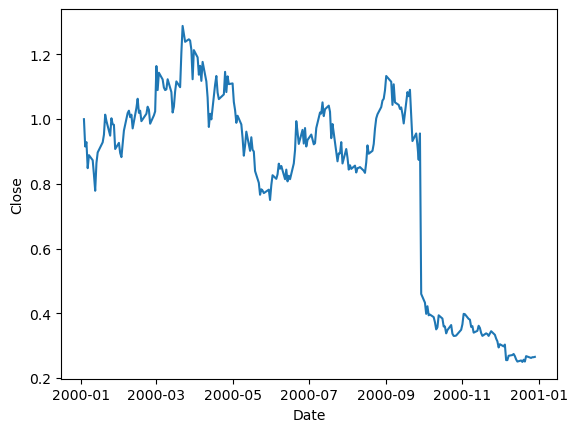

In [8]:
sns.lineplot(df[df['Date'].dt.strftime('%Y') == '2000'], x='Date', y='Close')

<Axes: xlabel='Date', ylabel='Close'>

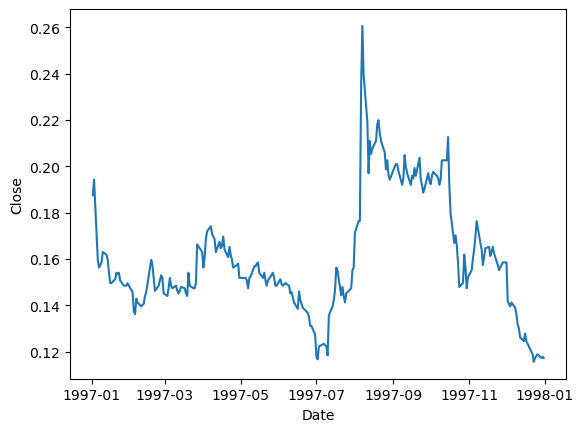

In [9]:
sns.lineplot(df[df['Date'].dt.strftime('%Y') == '1997'], x='Date', y='Close')

<Axes: xlabel='Date', ylabel='Close'>

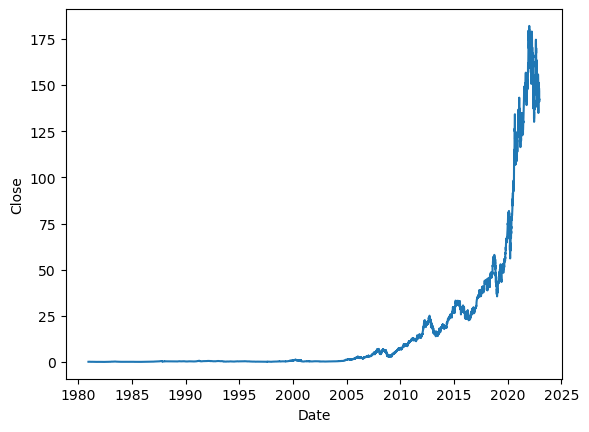

In [10]:
sns.lineplot(df, x='Date', y='Close')

In [11]:
LEARNING_RATE = 0.01
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 6
NUM_EPOCHS = 64

In [12]:
DEVICE

'cuda'

In [13]:
model = nn.RNN(10, 20, 2)
criterion = nn.MSELoss()

model.to(DEVICE)
criterion.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters())

In [14]:
# for epoch in tqdm(range(NUM_EPOCHS)):
#     input = 
#     target = 
#     output = model(input)
    
#     loss = criterion(output, target)
#     loss.backward()
    
#     optimizer.step()
#     optimizer.zero_grad()    